## <img src="./fiuba.jpg" align="right" width="150" /> 
#### Procesamiento Digital de Señales MSE2019 18PDS

# Trabajo Práctico 1
#### Pablo Slavkin

***
## Recepción de una señal degradada


<div class="alert alert-block alert-info">
<b>1)</b> a) Filtrar la señal con un filtro digital para eliminar potencia de ruido. Pueden probar
con filtros FIR o IIR, los que les parezcan convenientes.
¿Es óptimo el filtro elegido para detectar la información en forma confiable?

</div>

<div class="alert alert-block alert-warning">
<b>Respuesta:</b> Se levantan las seniales y se analizan sus espectros:</div>
 

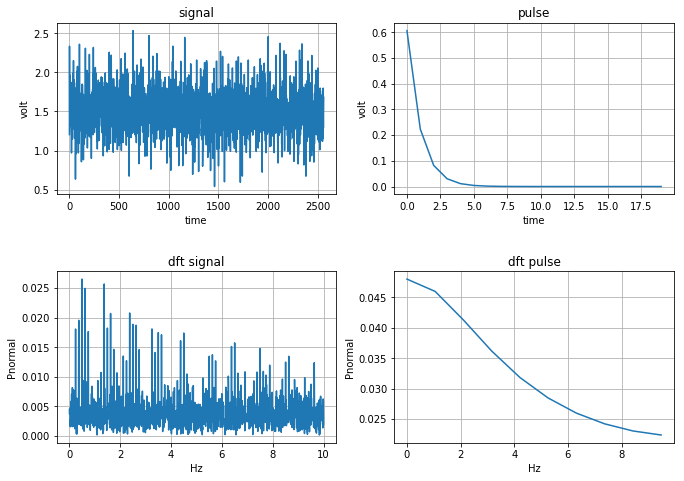

In [5]:
import  numpy   as np                                                                          
from    plotter import *                                                                       
from    filter  import *                                                                       
                                                                                               
fs    = 20                      #frecuencia de sampleo de la senial                            
pl    = plotter_class ( 2,2 )   #objeto para generar un grafico de 2x2                         
f     = filter_class  ( )       #objero para funciones de filtrado                             
                                                                                               
signal = np.load('signalLowSNR.npy')        #lee la senial a decodidicar                       
#signal = np.load('signal.npy')                                                                
signal=signal[:2560*1]                      #tomo una pocrion para debug, luego comentar       
pl.plot_signal  ( 1 ,pl.spaceX(signal) ,signal ,'signal' ,'time' ,'volt' ,trace='-' )          
                                                                                               
pulse  = np.load('pulse.npy')               #cargo el pulso original para plotearlo            
pl.plot_signal  ( 2 ,pl.spaceX(pulse)  ,pulse  ,'pulse'  ,'time' ,'volt' ,trace='-' )          
                                                                                               
pl.plot_dft_signal ( 3 ,fs ,signal ,'dft signal' ,'Hz' ,'Pnormal' ,trace='-' ,center=signal.size//2 ,zoom=signal.size//2-1)
pl.plot_dft_signal ( 4 ,fs ,pulse  ,'dft pulse'  ,'Hz' ,'Pnormal' ,trace='-')                                                  

pl.plot_show()   

<div class="alert alert-block alert-warning">
<b>Respuesta:</b> Se puede ver que tanto el espectro del pulso como el espectro de la senial tienen potencia distribuida en todo el espectro, con lo cual cualquiera sea el filtro que se elija para limitar la potencia de ruido que se aprecia en el espectro de signal, recortara un poco de la energia de la senial de interes. 
    Igualmente aun asi, se lograra aumentar un poco la SNR. Como se ve en el siguiente filtrado:    
</div>

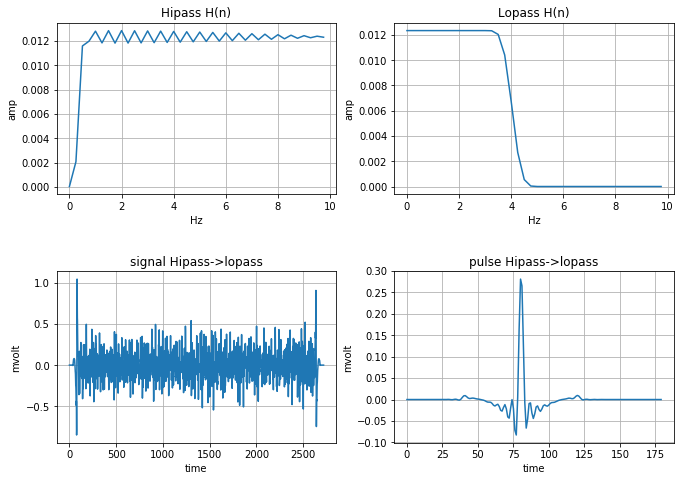

In [6]:
pl    = plotter_class ( 2,2 )       #nuevo grafico                                             
                                                                                               
hipass = np.load("hipass_fir.npz")['ba'][0]     #leo los parametros del pasabajo              
lopass = np.load("lopass_fir.npz")['ba'][0]     # y pasaaltos diseniados                       
pl.plot_dft_signal ( 1 ,fs,hipass,'Hipass H(n)' ,'Hz' ,'amp' ,trace='-' )                      
pl.plot_dft_signal ( 2 ,fs,lopass,'Lopass H(n)' ,'Hz' ,'amp' ,trace='-' )                      
                                                                                               
signal = f.fir ( signal ,hipass )               #aplico el filtrado a la senial y la muestro   
signal = f.fir ( signal ,lopass )                                                              
pl.plot_signal ( 3 ,pl.spaceX(signal ),signal ,'signal Hipass->lopass' ,'time' ,'mvolt' ,trace='-' )
                                                                                               
ans = f.fir ( pulse ,hipass )                   #aplico el filtrado al pulso para verificar que no este
ans = f.fir ( ans   ,lopass )                   #recortando demasiado                          
pl.plot_signal ( 4 ,pl.spaceX(ans    ),ans    ,'pulse Hipass->lopass'  ,'time' ,'mvolt' ,trace='-' )

pl.plot_show() 


<div class="alert alert-block alert-warning">
Se puede ver el resultado de la senial y el pulso filtrado y se aprecia como se ha recortado bastante la energia perdiendo parte de la senial    
</div>

<div class="alert alert-block alert-warning">
Con la senial mas limpia, se procede a decodificar. Se testean 2 tecnicas, una de umbral y otra de correlacion. En la primera se toma el primer sample de cada 20 (el largo del pulso) y se decide si es mayor o menor a cero para determinar si el pulso es un uno o un cero. Es decir de todos los 20 samples de energia del pulso solo se usa el primero. En la tecnica de correlacion en cambio se correlacionan los 20 samples que tiene la senial con el pulso original conocido y se toma el maximo para determinar si se 'parece' mas a un pulso positivo o negativo
</div>

tecnica umbral=
[172 172 172 172 172 172 172 188 172 172 172 172 172 172 172 172  64]
tecnica correlacion=
[172 172 172 172 172 172 172 188 172 172 172 172 172 173 172 172  64]


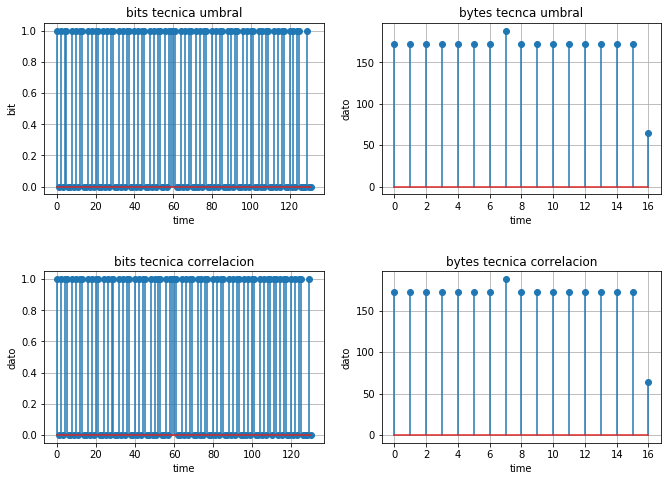

In [7]:
groupDelay  = hipass.size//2+lopass.size//2     #calculo el retado basado en el largo de la respuesta al impulso de cada filtro
signal      = signal[groupDelay+1:]             #demoro la senial original dicaha cantirdad,lo previo es descartado, notar el +!
#esto es lo importante, aca lo que hago es quedarme solo con el primer pulso de cada 20, que es el
#sample que tiene la mayor energia y es el que usare para comparar contra un umbral para decidir si
#el pulso es 1 o -1                                                                            
pl    = plotter_class ( 2,2 )                                                                  
                                                                                               
ans         = signal[::pulse.size]                                                             
ans[ans>=0] = 1                                 #digitalizo la senial con un comparador        
ans[ans<0]  = 0                                                                                
ans         = np.uint8(ans)                     #lo necesito apra empaquetar luego a bytes     
pl.stem_signal  ( 1 ,pl.spaceX(ans) ,ans ,'bits tecnica umbral'  ,'time' ,'bit'  ,trace='.' )  
                                                                                               
ans = np.packbits(ans)                          #empaqueto de 8 por comodidad                  
pl.stem_signal  ( 2 ,pl.spaceX(ans) ,ans ,'bytes tecnca umbral' ,'time' ,'dato' ,trace='.' )   
                                                                                               
print(f"tecnica umbral=\n{ans}")                                      #muestra los resultados  
                                                                                               
ans=np.zeros(0)                                                                                
ans2=np.zeros(0)                                                                               
for i in range(signal.size//pulse.size):                                                       
    ans=np.append(ans,np.correlate(signal[i*pulse.size:(i+1)*pulse.size],pulse))               
                                                                                               
ans[ans>=0] = 1                                 #digitalizo la senial con un comparador        
ans[ans<0]  = 0                                                                                
ans         = np.uint8(ans)                     #lo necesito apra empaquetar luego a bytes     
pl.stem_signal  ( 3 ,pl.spaceX(ans),ans ,'bits tecnica correlacion' , 'time' ,'dato'  ,trace='.' )
ans = np.packbits(ans)                          #empaqueto de 8 por comodidad                  
pl.stem_signal  ( 4 ,pl.spaceX(ans),ans ,'bytes tecnica correlacion' , 'time' ,'dato'  ,trace='.' )
print(f"tecnica correlacion=\n{ans}")                                      #muestra los resultados
                                                                                               
pl.plot_show()                                               

<div class="alert alert-block alert-warning">
Conclusion: Se filtro la senial y el pulso para eliminar el ruido teniendo en cuenta de no deteriorar demasiado la senial. Se utilizaron las tecnicas de umbral usando 1 solo sample y la de correlacion con el pulso original utilizando los 20 samples de cada pulso para la toma de decision y se obtuvieron resultados similares. A continuacion una decodificacion completa
</div>

tecnica umbral=
[172 172 172 172 172 172 172 188 172 172 172 172 172 172 172 172  68  66
 235 252 232  62 213 128 111  93  82 255 231 250 214 166 224  11 132  21
  58 103   2  36  28  75 128 163 211 253 164  40 100 115 213 232  71 145
 190 145 188 203  53  26 108 147  61 174  64 222 207 216 126 149 124  89
 124 202 165  85 213  36  81  45 111 169 209 149  89  95 143  37 123 169
 115 113 222  77  81  51 232 146  57  49 239 150 119 109  61 119 160  70
 150  70 248 209 134  99  27  64 206 134  38 212  82  67  80 171 149 172
  89 131 198 100 127   1 146 186  25  74  33 163 254 255 230 130 201 171
 225  88  72  32 176 129 138  25 235 230 216 129 143 248 106 208 235 181
  32  79 228 104 117  30 204  89  52  71 221 160 151  17 135 139  21 181
  62 144 183 116  11 122 221  76 189  83 210  30 119   0 200 250  99 232
 224 121 119  32   6 196]
tecnica correlacion=
[172 172 172 172 172 172 172 188 172 172 172 172 172 173 172 172  68  74
 235 252 232  62 213 128 111  93  82 255 231 250 214 166 224 

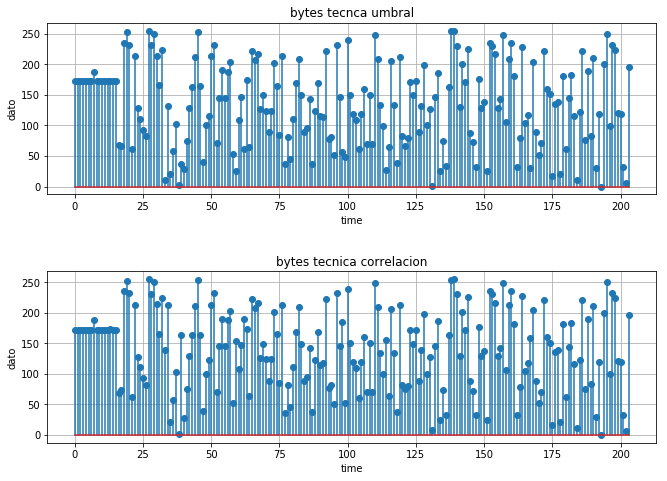

In [8]:
import  numpy   as np                                                                          
from    plotter import *                                                                       
from    dft     import *                                                                       
from    filter  import *                                                                       
from    dft     import *                                                                       
                                                                                               
fs    = 20                      #frecuencia de sampleo de la senial                            
pl    = plotter_class ( 2,1 )   #objeto para generar un grafico de 2x2                         
f     = filter_class  ( )       #objero para funciones de filtrado                             
                                                                                               
signal = np.load('signalLowSNR.npy')        #lee la senial a decodidicar                       
pulse  = np.load('pulse.npy')               #cargo el pulso original para plotearlo            
hipass = np.load("hipass_fir.npz")['ba'][0]     #leo los parametros del pasabajo              
lopass = np.load("lopass_fir.npz")['ba'][0]     # y pasaaltos diseniados                       
signal = f.fir ( signal ,hipass )               #aplico el filtrado a la senial y la muestro   
signal = f.fir ( signal ,lopass )                                                              
                                                                                               
groupDelay  = hipass.size//2+lopass.size//2     #calculo el retado basado en el largo de la respuesta al impulso de cada filtro
signal      = signal[groupDelay+1:]             #demoro la senial original dicaha cantirdad,lo previo es descartado, notar el +!
                                                                                               
ans         = signal[::pulse.size]                                                             
ans[ans>=0] = 1                                 #digitalizo la senial con un comparador        
ans[ans<0]  = 0                                                                                
ans         = np.uint8(ans)                     #lo necesito apra empaquetar luego a bytes        
ans = np.packbits(ans)                          #empaqueto de 8 por comodidad                  
pl.stem_signal  ( 1 ,pl.spaceX(ans) ,ans ,'bytes tecnca umbral' ,'time' ,'dato' ,trace='.' )   
                                                                                               
print(f"tecnica umbral=\n{ans}")                                      #muestra los resultados  
                                                                                               
ans=np.zeros(0)                                                                                
ans2=np.zeros(0)                                                                               
for i in range(signal.size//pulse.size):                                                       
    ans=np.append(ans,np.correlate(signal[i*pulse.size:(i+1)*pulse.size],pulse))               
                                                                                               
ans[ans>=0] = 1                                 #digitalizo la senial con un comparador        
ans[ans<0]  = 0                                                                                
ans         = np.uint8(ans)                     #lo necesito apra empaquetar luego a bytes        
ans = np.packbits(ans)                          #empaqueto de 8 por comodidad                  
pl.stem_signal  ( 2 ,pl.spaceX(ans),ans ,'bytes tecnica correlacion' , 'time' ,'dato'  ,trace='.' )
print(f"tecnica correlacion=\n{ans}")                                      #muestra los resultados
                                                                                               
pl.plot_show()                                                                                 
